In [3]:
import pandas as pd
import numpy as np
from cataclop.ml.pipeline import factories

In [ ]:
d = factories.Dataset.factory('default')
d.load(force=True)

In [13]:
pd.concat([pd.DataFrame(d.players.describe()).T, d.players.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,17355.0,4.542380e+00,1.989305e+00,2.0,3.0,4.0,6.000,1.400000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,17355.0,1.251541e+01,3.037875e+00,4.0,10.0,13.0,15.000,2.000000e+01,int64
distance,17355.0,1.920982e+03,4.800349e+02,950.0,1600.0,2000.0,2200.000,3.200000e+03,int64
earnings,17355.0,6.586432e+06,2.246027e+07,0.0,515000.0,2123300.0,6220250.000,1.471275e+09,int64


In [14]:
import time

df = d.players.groupby('race_id').filter(lambda race: race['race_count'].max() > 0)

races = df.groupby('race_id')

agg_features = ['race_count', 
                'victory_count', 
                'placed_2_count', 
                'placed_3_count',
                'victory_earnings',
                'prev_year_earnings',
                'handicap_distance',
                'handicap_weight'
               ]

stats = races[agg_features].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='inner')

for f in agg_features:
    df['{}_r'.format(f)] = df[f] - df['{}_mean'.format(f)] / df['{}_std'.format(f)]
    
agg_features = ['{}_r'.format(f) for f in agg_features]

df[agg_features] = df[agg_features].replace([np.inf, -np.inf], np.nan)
df[agg_features] = df[agg_features].fillna(1000)

odds = pd.DataFrame(columns=['odds_{:d}'.format(i) for i in range(20)], index=df.index)

races = df.groupby('race_id')

start = time.time()

for (id, race) in races:
    odds_sorted = sorted(race['final_odds_ref'].values)
    odds.loc[race.index, ['odds_{:d}'.format(i) for i, v in enumerate(odds_sorted)]] = odds_sorted
    
end = time.time()
print(end - start)

df = pd.concat([df,odds], axis=1)

df[['odds_{:d}'.format(i) for i in range(20)]] = df[['odds_{:d}'.format(i) for i in range(20)]].fillna(1000.0)

df['speed'] = (df['distance'] / df['time']).fillna(1000)
df['final_odds_ref_inv'] = (1. / df['final_odds_ref']).fillna(0.)

df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1)
df = df.sort_index()
df_orig = df.copy()

336.8711278438568


In [15]:
df = df_orig[df_orig['category']=='ATTELE'].copy()
df = df.sort_index()

In [223]:
df_test = df[df['start_at'] > '2017-11-20'].copy()
df = df[df['start_at'] <= '2017-11-20'].copy()

In [236]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

groups = df.index.droplevel(1).values

group_kfold = GroupKFold(n_splits=3)

features = agg_features

features = features + ['declared_player_count'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

features = features + ['odds_{:d}'.format(i) for i in range(20)]

N_TARGETS = 3

df['pred_pos'] = N_TARGETS
for i in range(N_TARGETS):
    df['pred_{}'.format(i+1)] = 0.0

df['target'] = df['position'].copy()
df.loc[df['target'] > N_TARGETS, 'target'] = N_TARGETS
df['target'].fillna(N_TARGETS, inplace=True)

splits = list(group_kfold.split(df.values, df['position'].values, groups))

from cataclop.ml import preprocessing

models = [
    {
        'name': 'rf_150',
        'model': RandomForestClassifier(n_estimators=150),
        'scaler': False
    },
    {
        'name': 'knn_5',
        'model': KNeighborsClassifier(n_neighbors=5),
        'scaler': False
    },
    {
        'name': 'knn_20',
        'model': KNeighborsClassifier(n_neighbors=20),
        'scaler': False
    },
    {
        'name': 'knn_30',
        'model': KNeighborsClassifier(n_neighbors=20),
        'scaler': False
    },
    {
        'name': 'knn_40',
        'model': KNeighborsClassifier(n_neighbors=20),
        'scaler': False
    },
    {
        'name': 'knn_50',
        'model': KNeighborsClassifier(n_neighbors=50),
        'scaler': False
    },
    {
        'name': 'knn_100',
        'model': KNeighborsClassifier(n_neighbors=100),
        'scaler': False
    },
    {
        'name': 'knn_150',
        'model': KNeighborsClassifier(n_neighbors=150),
        'scaler': False
    }
]
'''
    {
        'name': 'rf_150',
        'model': RandomForestClassifier(n_estimators=150),
        'scaler': False
    },
    {
        'name': 'rf_100',
        'model': RandomForestClassifier(n_estimators=100),
        'scaler': False
    },
{
    'name': 'nn_100',
    'model': MLPClassifier(),
    'scaler': True
}
{
    'name': 'knn_5',
    'model': KNeighborsClassifier(n_neighbors=5),
    'scaler': False
},
{
    'name': 'ada',
    'model': AdaBoostClassifier(),
    'scaler': False
},

{
    'name': 'rf_50',
    'model': RandomForestClassifier(n_estimators=50),
    'scaler': False
},
{
    'name': 'svc',
    'model': SVC(probability=True),
    'scaler': True
}
'''
for model in models:
    for i in range(N_TARGETS):
        df['pred_{}_{}'.format(model['name'], i+1)] = 0.0
        df_test['pred_{}_{}'.format(model['name'], i+1)] = 0.0

    df['pred_{}'.format(model['name'])] = 0.0

for train_index, test_index in splits:
    
    for model in models:

        X_train = df[features].iloc[train_index].copy()
        y_train = df['target'].iloc[train_index]

        dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
        X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
        
        X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
        y_train = df['target'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]

        X_test = df[features].iloc[test_index].copy()
        y_test = df['target'].iloc[test_index]
    
        X_val = df_test[features].copy()

        X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
        X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

        X_train = X_train.values
        X_test = X_test.values
        X_val = X_val.values

        idx = df.iloc[test_index].index

        if model['scaler']:
            scaler = StandardScaler()
            scaler.fit(X_train)

            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            X_val = scaler.transform(X_val)

        clf = model['model']
        clf.fit(X_train, y_train.values)

        p = clf.predict_proba(X_test)
    
        print( model['name'], log_loss(y_test.values, p) )

        for i in range(N_TARGETS):
            df.loc[idx, 'pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

        df.loc[idx, 'pred_{}'.format(model['name'])] = p[:, list(clf.classes_).index(1)]
    
        p = clf.predict_proba(X_val)
    
        for i in range(N_TARGETS):
            df_test['pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

    
    
    
    

rf_150 0.6327761186485051
knn_5 3.093604721788309
knn_20 0.7217346221704383
knn_30 0.7217346221704383
knn_40 0.7217346221704383
knn_50 0.5694012405303164
knn_100 0.5714588000840819
knn_150 0.5687694845752782
rf_150 0.6043720416132227
knn_5 3.0448817243567308
knn_20 0.8120597648011644
knn_30 0.8120597648011644
knn_40 0.8120597648011644
knn_50 0.5719432652557437
knn_100 0.5695466897459256
knn_150 0.5674499676411844
rf_150 0.6239369670025717
knn_5 2.791958054420242
knn_20 0.9618053785036275
knn_30 0.9618053785036275
knn_40 0.9618053785036275
knn_50 0.6202181897183847
knn_100 0.5743613496515899
knn_150 0.5719034889410592


In [237]:
from sklearn.linear_model import LogisticRegression

N_TARGETS_STACKED = 3

df['target_stacked'] = df['position'].copy()
df.loc[df['target_stacked'] > N_TARGETS_STACKED, 'target_stacked'] = N_TARGETS_STACKED
df['target_stacked'].fillna(N_TARGETS_STACKED, inplace=True)

df['pred_stacked'] = 0.0
for i in range(N_TARGETS_STACKED):
    df['pred_stacked_{}'.format(i+1)] = 0.0
    df_test['pred_stacked_{}'.format(i+1)] = 0.0


#stacked_features = ['pred_{}'.format(model['name']) for model in models]
stacked_features = []

for i in range(N_TARGETS):
    stacked_features = stacked_features + ['pred_{}_{}'.format(model['name'], i+1) for model in models]

#stacked_features = stacked_features + ['final_odds_ref_inv']

for train_index, test_index in splits:

    X_train = df[stacked_features].iloc[train_index].copy()
    y_train = df['target_stacked'].iloc[train_index]

    dummies = preprocessing.get_dummies(df.iloc[train_index], [])
    X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
    
    X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
    y_train = df['target'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]


    X_test = df[stacked_features].iloc[test_index].copy()
    y_test = df['target_stacked'].iloc[test_index]
    
    X_val = df_test[stacked_features].copy()

    X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
    X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

    X_train = X_train.values
    X_test = X_test.values
    X_val = X_val.values

    idx = df.iloc[test_index].index
    
    scaler = Normalizer()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    print(X_train[0:1])

    #clf = MLPClassifier(hidden_layer_sizes=(10,10,10), activation='relu')
    clf = RandomForestClassifier(n_estimators=100)
    #clf = AdaBoostClassifier(n_estimators=250)
    #clf = SVC(probability=True)
    #clf = KNeighborsClassifier(n_neighbors=25)

    clf.fit(X_train, y_train.values)

    p = clf.predict_proba(X_test)
    
    print( log_loss(y_test.values, p) )

    df.loc[idx, 'pred_stacked'] = p[:, list(clf.classes_).index(1)]
    for i in range(N_TARGETS_STACKED):
        df.loc[idx, 'pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]

    p = clf.predict_proba(X_val)
    
    for i in range(N_TARGETS_STACKED):
        df_test['pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]



[[0.05715861 0.         0.04286896 0.04286896 0.04286896 0.04286896
  0.05144275 0.0657324  0.02000551 0.         0.04286896 0.04286896
  0.04286896 0.05144275 0.05572964 0.06001654 0.35152543 0.42868955
  0.34295164 0.34295164 0.34295164 0.33437785 0.32151716 0.30294062]]
0.6477221363521594
[[0.03256919 0.08882506 0.0666188  0.0666188  0.0666188  0.07994256
  0.07550131 0.07698172 0.04737337 0.         0.02220627 0.02220627
  0.02220627 0.03553003 0.04885379 0.04737337 0.36418277 0.35530026
  0.35530026 0.35530026 0.35530026 0.32865274 0.31977023 0.31977023]]
0.6179315905419634
[[0.05715861 0.         0.04286896 0.04286896 0.04286896 0.04286896
  0.05144275 0.0657324  0.02000551 0.         0.04286896 0.04286896
  0.04286896 0.05144275 0.05572964 0.06001654 0.35152543 0.42868955
  0.34295164 0.34295164 0.34295164 0.33437785 0.32151716 0.30294062]]
0.6437721977872225


In [238]:
df_test[['position', 'final_odds_ref', 'pred_stacked_1']+['pred_{}'.format(m['name']) for m in models]][:10]

position  final_odds_ref  pred_stacked_1  pred_rf_150  \
race_id id                                                             
2160    15306      13.0            45.0            0.07     0.066667   
        15307       1.0             6.2            0.05     0.113333   
        15308       4.0             4.5            0.10     0.153333   
        15309      12.0            53.9            0.01     0.126667   
        15310       3.0            17.5            0.08     0.073333   
        15311       7.0            15.5            0.11     0.146667   
        15312       6.0             7.0            0.19     0.153333   
        15313       9.0            13.4            0.13     0.153333   
        15314      10.0             5.7            0.02     0.173333   
        15315       NaN            27.8            0.11     0.066667   

               pred_knn_5  pred_knn_20  pred_knn_30  pred_knn_40  pred_knn_50  \
race_id id                                                                      
2160    15306         0.2         0.15         0.15         0.15         0.16   
        15307         0.2         0.15         0.15         0.15         0.14   
        15308         0.0         0.15         0.15         0.15         0.10   
        15309         0.0         0.10         0.10         0.10         0.12   
        15310         0.2         0.15         0.15         0.15         0.14   
        15311         0.0         0.15         0.15         0.15         0.12   
        15312         0.2         0.20         0.20         0.20         0.16   
        15313         0.0         0.10         0.10         0.10         0.14   
        15314         0.0         0.10         0.10         0.10         0.14   
        15315         0.2         0.10         0.10         0.10         0.18   

               pred_knn_100  pred_knn_150  
race_id id                                 
2160    15306          0.14      0.133333  
        15307          0.14      0.133333  
        15308          0.13      0.140000  
        15309          0.13      0.140000  
        15310          0.15      0.133333  
        15311          0.14      0.140000  
        15312          0.14      0.146667  
        15313          0.14      0.133333  
        15314          0.13      0.140000  
        15315          0.15      0.173333

In [239]:
fi = pd.Series(clf.feature_importances_, index=stacked_features+preprocessing.get_dummy_features(dummies))
print(fi.sort_values(ascending=False))

pred_rf_150_1     0.062121
pred_rf_150_3     0.060654
pred_knn_5_3      0.056561
pred_knn_150_1    0.050201
pred_knn_50_1     0.049196
pred_knn_150_2    0.047448
pred_rf_150_2     0.045432
pred_knn_100_1    0.045382
pred_knn_100_2    0.044037
pred_knn_150_3    0.042757
pred_knn_30_3     0.042560
pred_knn_100_3    0.042429
pred_knn_40_3     0.042224
pred_knn_50_3     0.041923
pred_knn_50_2     0.038980
pred_knn_30_1     0.036625
pred_knn_20_2     0.035509
pred_knn_20_3     0.035006
pred_knn_20_1     0.034689
pred_knn_40_1     0.033528
pred_knn_40_2     0.033201
pred_knn_30_2     0.031671
pred_knn_5_1      0.027066
pred_knn_5_2      0.020801
dtype: float64


In [255]:
df_test['strat_1'] = df_test['pred_stacked_1']

races = df_test.groupby('race_id')

bets = []

for (id, race) in races:
    
    nums = []
    
    for k, target in enumerate(['strat_1'], 1):
    
        r = race.sort_values(by=target, ascending=False)

        r = r[(r['final_odds_ref']<30.) & (r['final_odds_ref'] > 1)]

        if len(r) == 0:
            continue

        player = r.iloc[0]
        
        if player['num'] in nums:
            continue
            
        odds = player['final_odds_ref']
        
        '''
        
        if player['pred_1'] < 0.1:
            continue
        if player['pred_2'] < 0.075:
            continue
        if player['pred_3'] < 0.05:
            continue
            
        '''
        
        
        bet = 1#np.log(player['final_odds_ref'])#player['pred_1'] + player['pred_2']/2. + player['pred_3']/3.
        
        if odds < 3:
            bet = 1
        elif odds < 10:
            bet = 1
        else:
            bet = 1

        profit = player['winner_dividend']/100.0 * bet - bet

        bets.append( (id, player['sub_category'], player['start_at'], bet, player['position'], player['final_odds'], player['pred_stacked_1'], player['pred_stacked_2'], player['pred_stacked_3'], player['num'], profit) )
        
        nums.append(player['num'])



bets = pd.DataFrame(bets, columns=['id', 'cat', 'date', 'bet', 'pos', 'odds', 'pred_1', 'pred_2', 'pred_3', 'num', 'profit'])


bets.index = bets['date']

bets = bets.sort_index()

bets['stash'] = bets['profit'].cumsum()


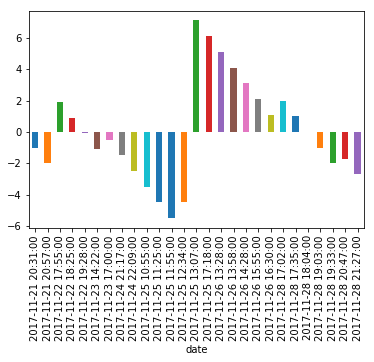

In [256]:
import matplotlib
%matplotlib inline
bets['stash'].plot(kind='bar')

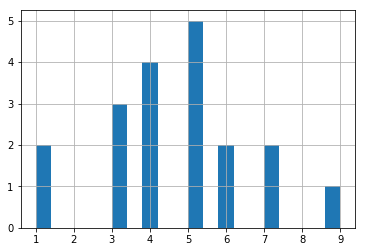

In [251]:
bets['pos'].hist(bins=20)

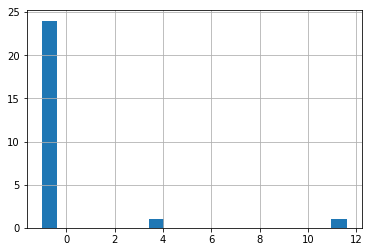

In [252]:
bets['profit'].hist(bins=20)

In [244]:
bets[0:100]

,id,cat,date,bet,pos,odds,pred_1,pred_2,pred_3,num,profit,stash
date,,,,,,,,,,,,
2017-11-21 20:31:00,2160,APPRENTIS_LADS_JOCKEYS_AUTOSTART,2017-11-21 20:31:00,1,6.0,4.9,0.190000,0.08,0.730000,7,-1.0,-1.000000e+00
2017-11-21 20:57:00,2161,AUTOSTART,2017-11-21 20:57:00,1,4.0,6.9,0.220000,0.07,0.710000,5,-1.0,-2.000000e+00
2017-11-22 17:55:00,2202,AUTOSTART,2017-11-22 17:55:00,1,1.0,4.8,0.400000,0.25,0.350000,5,3.9,1.900000e+00
2017-11-22 18:25:00,2203,AUTOSTART,2017-11-22 18:25:00,1,NaN,27.9,0.420000,0.16,0.420000,3,-1.0,9.000000e-01
2017-11-22 19:28:00,2205,INTERNATIONALE_AUTOSTART,2017-11-22 19:28:00,1,3.0,10.4,0.440000,0.15,0.410000,3,-1.0,-1.000000e-01
2017-11-23 14:22:00,2213,AUTOSTART,2017-11-23 14:22:00,1,6.0,3.3,0.270000,0.10,0.630000,8,-1.0,-1.100000e+00
2017-11-23 17:00:00,2218,AUTOSTART,2017-11-23 17:00:00,1,1.0,1.6,0.260000,0.11,0.630000,5,0.6,-5.000000e-01
2017-11-24 21:17:00,2255,AUTOSTART,2017-11-24 21:17:00,1,NaN,7.2,0.200000,0.16,0.640000,11,-1.0,-1.500000e+00
2017-11-24 22:09:00,2257,AUTOSTART,2017-11-24 22:09:00,1,5.0,14.4,0.450000,0.10,0.450000,3,-1.0,-2.500000e+00


cat     AMATEURS_AUTOSTART  APPRENTIS_LADS_JOCKEYS_AUTOSTART  AUTOSTART  \
profit                -1.0                              -1.0   0.095238   
profit                 1.0                               1.0  21.000000   

cat     EUROPEENNE_AUTOSTART  INTERNATIONALE_AUTOSTART  
profit                  -1.0                 -0.566667  
profit                   1.0                  3.000000  


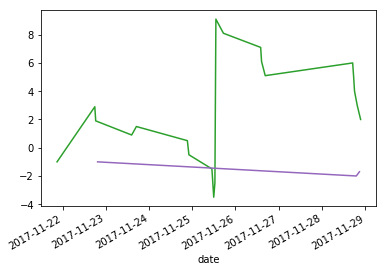

In [245]:
bets_cat = bets.groupby('cat')

print( pd.DataFrame([bets_cat['profit'].mean(), bets_cat['profit'].count()]) )

for cat, b in bets_cat:
    b['profit'].cumsum().plot(label=cat)
